In [1]:
import os
import neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the dataframes

In [21]:
file1 = '/Users/jonaheaton/Desktop/All April12 1pm part1.csv'
file2 = '/Users/jonaheaton/Desktop/All April12 1pm part2.csv'
df2 = pd.read_csv(file2, index_col=0)
df1 = pd.read_csv(file1, index_col=0)
df = df1.join(df2, how='outer', lsuffix='_1', rsuffix='_2')

## Cleanup and Simplify the dataframe to the essential bits

In [22]:
pretrain_objectives = ['Reconstruction Loss (val)',' StudyID AUC (val)', 'CohortLabel AUC (val)','Gender AUC (val)','AgeGroup AUC (val)', 'Age MAE (val)']


finetune_objectives = ['MSKCC AUC (finetune, val)', 'MSKCC AUC (finetune, train)', 'MSKCC AUC (randinit, val)',\
                       'IMDC AUC (finetune, val)', 'IMDC AUC (finetune, train)', 'IMDC AUC (randinit, val)']

key_params = ['Latent dim', '# hidden layers','']#, 'Learning Rate', 'Num Epochs']


search_dct = {
    'Reconstruction Loss (val)': {
        'must_contain_all': ['recon','val'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'StudyID AUC (val)': {
        'must_contain_all': ['StudyID','AUROC','val'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'CohortLabel AUC (val)': {
        'must_contain_all': ['AUROC','val'],
        'must_contain_one': ['CohortLabel','Cohort Label'],
        'exact_matches': []
    },
    'Gender AUC (val)': {
        'must_contain_all': ['AUROC','val'],
        'must_contain_one': ['isFemale','Gender'],
        'exact_matches': []
    },
    'AgeGroup AUC (val)': {
        'must_contain_all': ['AUROC','val','isPediatric'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'Age MAE (val)': {
        'must_contain_all': ['MAE','val'],
        'must_contain_one': ['Age'],
        'exact_matches': []
    },
    'MSKCC AUC (finetune, val)': {
        'must_contain_all': ['MSKCC','finetune','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'MSKCC AUC (finetune, train)': {
        'must_contain_all': ['MSKCC','finetune','train'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['variance','std'],
        'exact_matches': []
    },
    'MSKCC AUC (randinit, val)': {
        'must_contain_all': ['MSKCC','randinit','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'IMDC AUC (finetune, val)': {
        'must_contain_all': ['IMDC','finetune','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'IMDC AUC (finetune, train)': {
        'must_contain_all': ['IMDC','finetune','train'],
        'must_contain_one': ['AUROC','AUC'],
        'exact_matches': [],
        'must_not_contain': ['variance','std'],
    },
    'IMDC AUC (randinit, val)': {
        'must_contain_all': ['IMDC','randinit','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'Latent dim': {
        'must_contain_all': ['latent'],
        'must_contain_one': [],
        'exact_matches': []
    },
    '# hidden layers': {
        'must_contain_all': ['layers'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'encoder kind':{
        'must_contain_all': ['encoder','kind'],
        'must_contain_one': [],
        'exact_matches': []
    },
}




In [23]:
# find the matches to the search dictionary for each important objective/parameter

input_cols = df.columns
selected_cols = []

for obj in search_dct.keys():

    print(obj)
    for col in df.columns:
        
        # first check of the column is already selected for an objective
        if col in selected_cols:
            continue

        # then check for exact matches
        if col in search_dct[obj]['exact_matches']:
            # print(obj, col)
            selected_cols.append(col)

        # then check if the column contains all of the must_contain_all words
        elif len(search_dct[obj]['must_contain_all'])==0 or all([x.lower() in col.lower() for x in search_dct[obj]['must_contain_all']]):
            if len(search_dct[obj]['must_contain_one'])==0 or any([x.lower() in col.lower() for x in search_dct[obj]['must_contain_one']]):
                if len(search_dct[obj].get('must_not_contain', []))==0 or all([x.lower() not in col.lower() for x in search_dct[obj].get('must_not_contain', [])]):

                    # print(obj, col)
                    selected_cols.append(col)
            
                    search_dct[obj]['exact_matches'].append(col)
            

Reconstruction Loss (val)
StudyID AUC (val)
CohortLabel AUC (val)
Gender AUC (val)
AgeGroup AUC (val)
Age MAE (val)
MSKCC AUC (finetune, val)
MSKCC AUC (finetune, train)
MSKCC AUC (randinit, val)
IMDC AUC (finetune, val)
IMDC AUC (finetune, train)
IMDC AUC (randinit, val)
Latent dim
# hidden layers
encoder kind


In [24]:
# use the search_dct to create a new dataframe from the selected columns

df = df[selected_cols].copy()

for obj in search_dct.keys():
    if len(search_dct[obj]['exact_matches'])==0:
        print(obj, 'not found')
        continue

    if len(search_dct[obj]['exact_matches'])==1:
        # rename the column to the objective name
        df = df.rename(columns={search_dct[obj]['exact_matches'][0]: obj})
    
    else:
        print(obj, 'multiple matches', search_dct[obj]['exact_matches'])
        # merge the columns into a single column
        # if the columns are numeric then take the mean
        if all(df[search_dct[obj]['exact_matches']].dtypes != 'object'):
            df[obj] = df[search_dct[obj]['exact_matches']].mean(axis=1) # ignore nan
            
        else:
            # if the columns are not numeric then take the first one
            df[obj] = df[search_dct[obj]['exact_matches'][0]]
        df = df.drop(columns=search_dct[obj]['exact_matches'])
        


Reconstruction Loss (val) multiple matches ['val recon loss', 'Val reconstruction_loss', 'pretrain/eval/val/reconstruction_loss (last)']
StudyID AUC (val) multiple matches ['val StudyID AUROC', 'pretrain/eval/val/MultiClass_Adv StudyID__AUROC (ovo, macro) (last)']
CohortLabel AUC (val) multiple matches ['val Cohort Label AUROC', 'pretrain/eval/val/MultiClass_Cohort Label__AUROC (ovo, macro) (last)']
Gender AUC (val) multiple matches ['val isFemale AUROC', 'pretrain/eval/val/Binary_isFemale__AUROC (micro) (last)']
AgeGroup AUC (val) multiple matches ['val isPediatric AUROC', 'pretrain/eval/val/Binary_isPediatric__AUROC (micro) (last)']
Age MAE (val) multiple matches ['val Age MAE', 'pretrain/eval/val/Regression_Age__MAE (last)']
MSKCC AUC (finetune, val) multiple matches ['MSKCC AUC finetune Val (v1)', 'MSKCC_finetune/eval/val/Binary_MSKCC__AUROC (micro) (average)']
MSKCC AUC (finetune, train) multiple matches ['MSKCC AUC finetune Train (v1)', 'MSKCC_finetune/eval/train/Binary_MSKCC__AU

In [25]:
df

,Latent dim,# hidden layers,Reconstruction Loss (val),StudyID AUC (val),CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),Age MAE (val),"MSKCC AUC (finetune, val)","MSKCC AUC (finetune, train)","MSKCC AUC (randinit, val)","IMDC AUC (finetune, val)","IMDC AUC (finetune, train)","IMDC AUC (randinit, val)",encoder kind
Id,,,,,,,,,,,,,,,
RCC-1000,8.0,2.0,0.615857,0.762010,NaN,NaN,0.995434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1001,8.0,2.0,0.646021,0.879790,0.992842,NaN,0.996190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1002,8.0,2.0,0.595628,0.601806,NaN,NaN,0.619367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1003,8.0,2.0,0.599536,0.616415,0.573812,NaN,0.635276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1004,8.0,2.0,0.622126,0.796842,NaN,NaN,0.974340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-995,8.0,1.0,0.605717,0.871321,0.988293,NaN,0.995399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-996,8.0,2.0,0.722247,0.604794,NaN,NaN,0.587050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-997,8.0,2.0,0.623891,0.796035,0.850271,NaN,0.978337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE


In [26]:
df['model complexity'] = df['Latent dim']*df['# hidden layers']
df['MSKCC AUC Diff (finetune-randinit)'] = df['MSKCC AUC (finetune, val)'] - df['MSKCC AUC (randinit, val)']
df['IMDC AUC Diff (finetune-randinit)'] = df['IMDC AUC (finetune, val)'] - df['IMDC AUC (randinit, val)']

In [27]:
df.dropna(subset=['Gender AUC (val)','Age MAE (val)'], inplace=True)

# drop outliers in the Age MAE
df = df[df['Age MAE (val)']<100].copy()


## Now that it is clean we can do analysis

In [28]:
pretrain_objectives = ['Reconstruction Loss (val)','StudyID AUC (val)', 'CohortLabel AUC (val)','Gender AUC (val)','AgeGroup AUC (val)', 'Age MAE (val)']


finetune_objectives = ['MSKCC AUC (finetune, val)', 'MSKCC AUC (finetune, train)', 'MSKCC AUC (randinit, val)',\
                       'IMDC AUC (finetune, val)', 'IMDC AUC (finetune, train)', 'IMDC AUC (randinit, val)']

key_params = ['Latent dim', '# hidden layers','model complexity']#, 'Learning Rate', 'Num Epochs']

key_cols = pretrain_objectives+finetune_objectives+key_params

In [29]:
df['encoder kind'].value_counts()

encoder kind
AE              310
VAE             149
TGEM_Encoder      1
Name: count, dtype: int64

In [30]:
ae_models = df[df['encoder kind']=='AE'].copy()
vae_models = df[df['encoder kind']=='VAE'].copy()


In [31]:
ae_models.sort_values('Age MAE (val)',ascending=True, inplace=True)
ae_models.sort_values('Gender AUC (val)', inplace=True, ascending=False)
ae_models.to_csv('/Users/jonaheaton/Desktop/ae_models.csv')


vae_models.sort_values('Age MAE (val)',ascending=True, inplace=True)
vae_models.sort_values('Gender AUC (val)', inplace=True, ascending=False)
vae_models.to_csv('/Users/jonaheaton/Desktop/vae_models.csv')

In [32]:
def update_directions_and_scales(df):

    df['neg log Reconstruction Loss (val)'] = -1* np.log(df['Reconstruction Loss (val)'])
    # remove the old column
    df = df.drop(columns=['Reconstruction Loss (val)'])

    df['neg Age MAE'] = -1*df['Age MAE (val)']
    df['neg Age MSE'] = -1*df['Age MAE (val)']
    df['neg StudyID AUC (val)'] = -1*df['StudyID AUC (val)']
    df.drop(columns=['Age MAE (val)','Age MAE (val)','StudyID AUC (val)'], inplace=True)

    # drop any non-numeric columns
    df = df.select_dtypes(include=[np.number]).copy()

    return df

In [33]:
ae_model_clean = update_directions_and_scales(ae_models.copy())


In [34]:
ae_model_clean

,Latent dim,# hidden layers,CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),"MSKCC AUC (finetune, val)","MSKCC AUC (finetune, train)","MSKCC AUC (randinit, val)","IMDC AUC (finetune, val)","IMDC AUC (finetune, train)","IMDC AUC (randinit, val)",model complexity,MSKCC AUC Diff (finetune-randinit),IMDC AUC Diff (finetune-randinit),neg log Reconstruction Loss (val),neg Age MAE,neg Age MSE,neg StudyID AUC (val)
Id,,,,,,,,,,,,,,,,,,
RCC-2116,43.0,6.0,0.873298,0.880906,0.995580,0.863889,0.999833,0.500000,0.886480,0.999865,0.808625,258.0,0.363889,0.077855,0.053261,-9.807319,-9.807319,-0.860958
RCC-2044,17.0,3.0,0.958810,0.875962,0.994730,0.846032,0.992583,0.874206,0.892075,0.997641,0.883450,51.0,-0.028175,0.008625,0.437010,-9.469346,-9.469346,-0.858232
RCC-2348,25.0,7.0,0.984944,0.875495,0.996603,0.852249,0.999833,0.872884,0.883683,1.000000,0.727040,175.0,-0.020635,0.156643,0.597194,-10.397836,-10.397836,-0.879170
RCC-2103,49.0,1.0,0.976431,0.872182,0.994132,0.869709,0.997317,0.869974,0.907925,0.999831,0.889044,49.0,-0.000265,0.018881,0.507174,-9.571028,-9.571028,-0.896720
RCC-2362,30.0,7.0,0.833379,0.871898,0.991234,0.816799,0.944967,0.648677,0.886014,0.963869,0.871329,210.0,0.168122,0.014685,0.053261,-10.800716,-10.800716,-0.789652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-2079,62.0,7.0,0.831433,0.463905,0.979959,0.812235,0.911858,0.502513,0.903730,0.957449,0.809324,434.0,0.309722,0.094406,0.053381,-10.500202,-10.500202,-0.807150
RCC-2337,42.0,10.0,0.636314,0.461642,0.667207,0.737566,0.780908,0.597950,0.806760,0.829946,0.801399,420.0,0.139616,0.005361,0.028078,-9.854049,-9.854049,-0.674600
RCC-2341,40.0,8.0,0.706459,0.460656,0.833314,0.739683,0.810442,0.574868,0.877040,0.872784,0.871212,320.0,0.164815,0.005828,0.056913,-9.854291,-9.854291,-0.690749


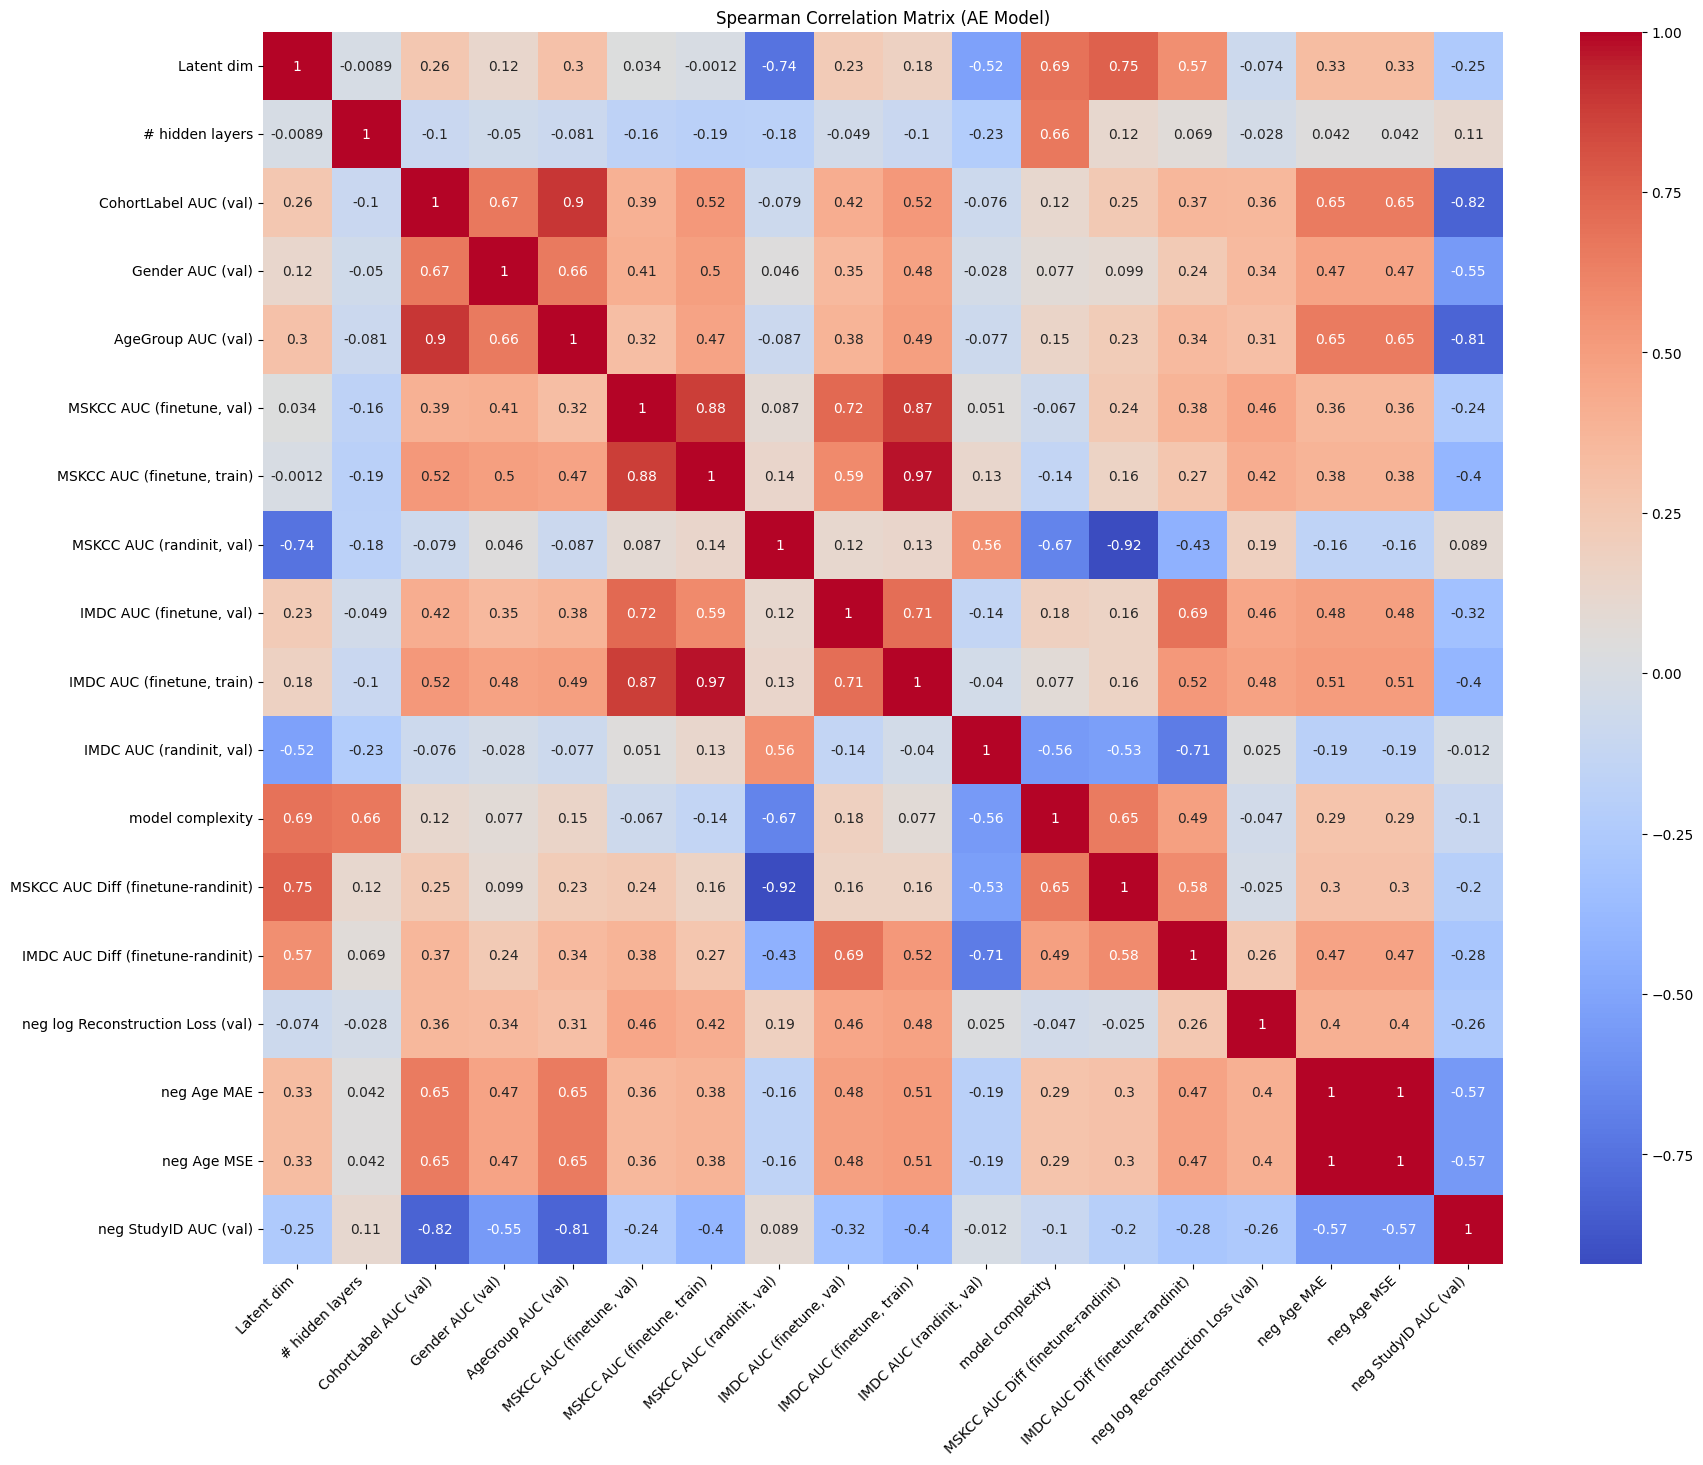

In [35]:
# Compute the correlation matrix

corr_matrix = ae_model_clean.corr(method='spearman')

# Plot the correlation matrix
# make the plot bigger
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix (AE Model)')

# rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.savefig('/Users/jonaheaton/Desktop/ae_correlation_matrix.png')

<Figure size 2600x2400 with 0 Axes>

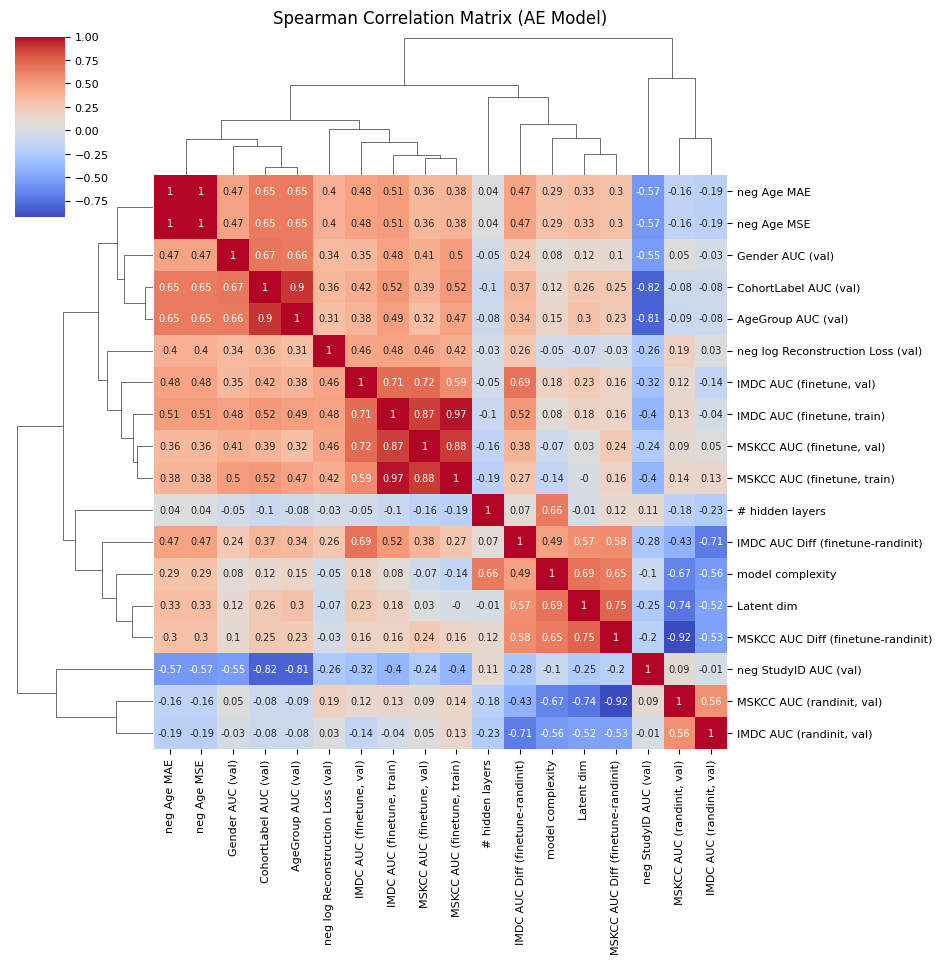

In [36]:
# sns.set_context('notebook')
nonan_corr_matrix = corr_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all')
nonan_corr_matrix = nonan_corr_matrix.dropna(axis=0).dropna(axis=1).round(2)

plt.figure(figsize=(26, 24))
cax = sns.clustermap(nonan_corr_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 7})
plt.xticks(rotation=45, ha='right')

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# Set axis label size
cax.ax_heatmap.tick_params(axis='both', which='both', labelsize=8)

# add a title to the clustergird
cax.ax_col_dendrogram.set_title('Spearman Correlation Matrix (AE Model)')

plt.savefig('/Users/jonaheaton/Desktop/ae_clustered_correlation_matrix.png')

In [37]:
vae_model_clean = update_directions_and_scales(vae_models.copy())

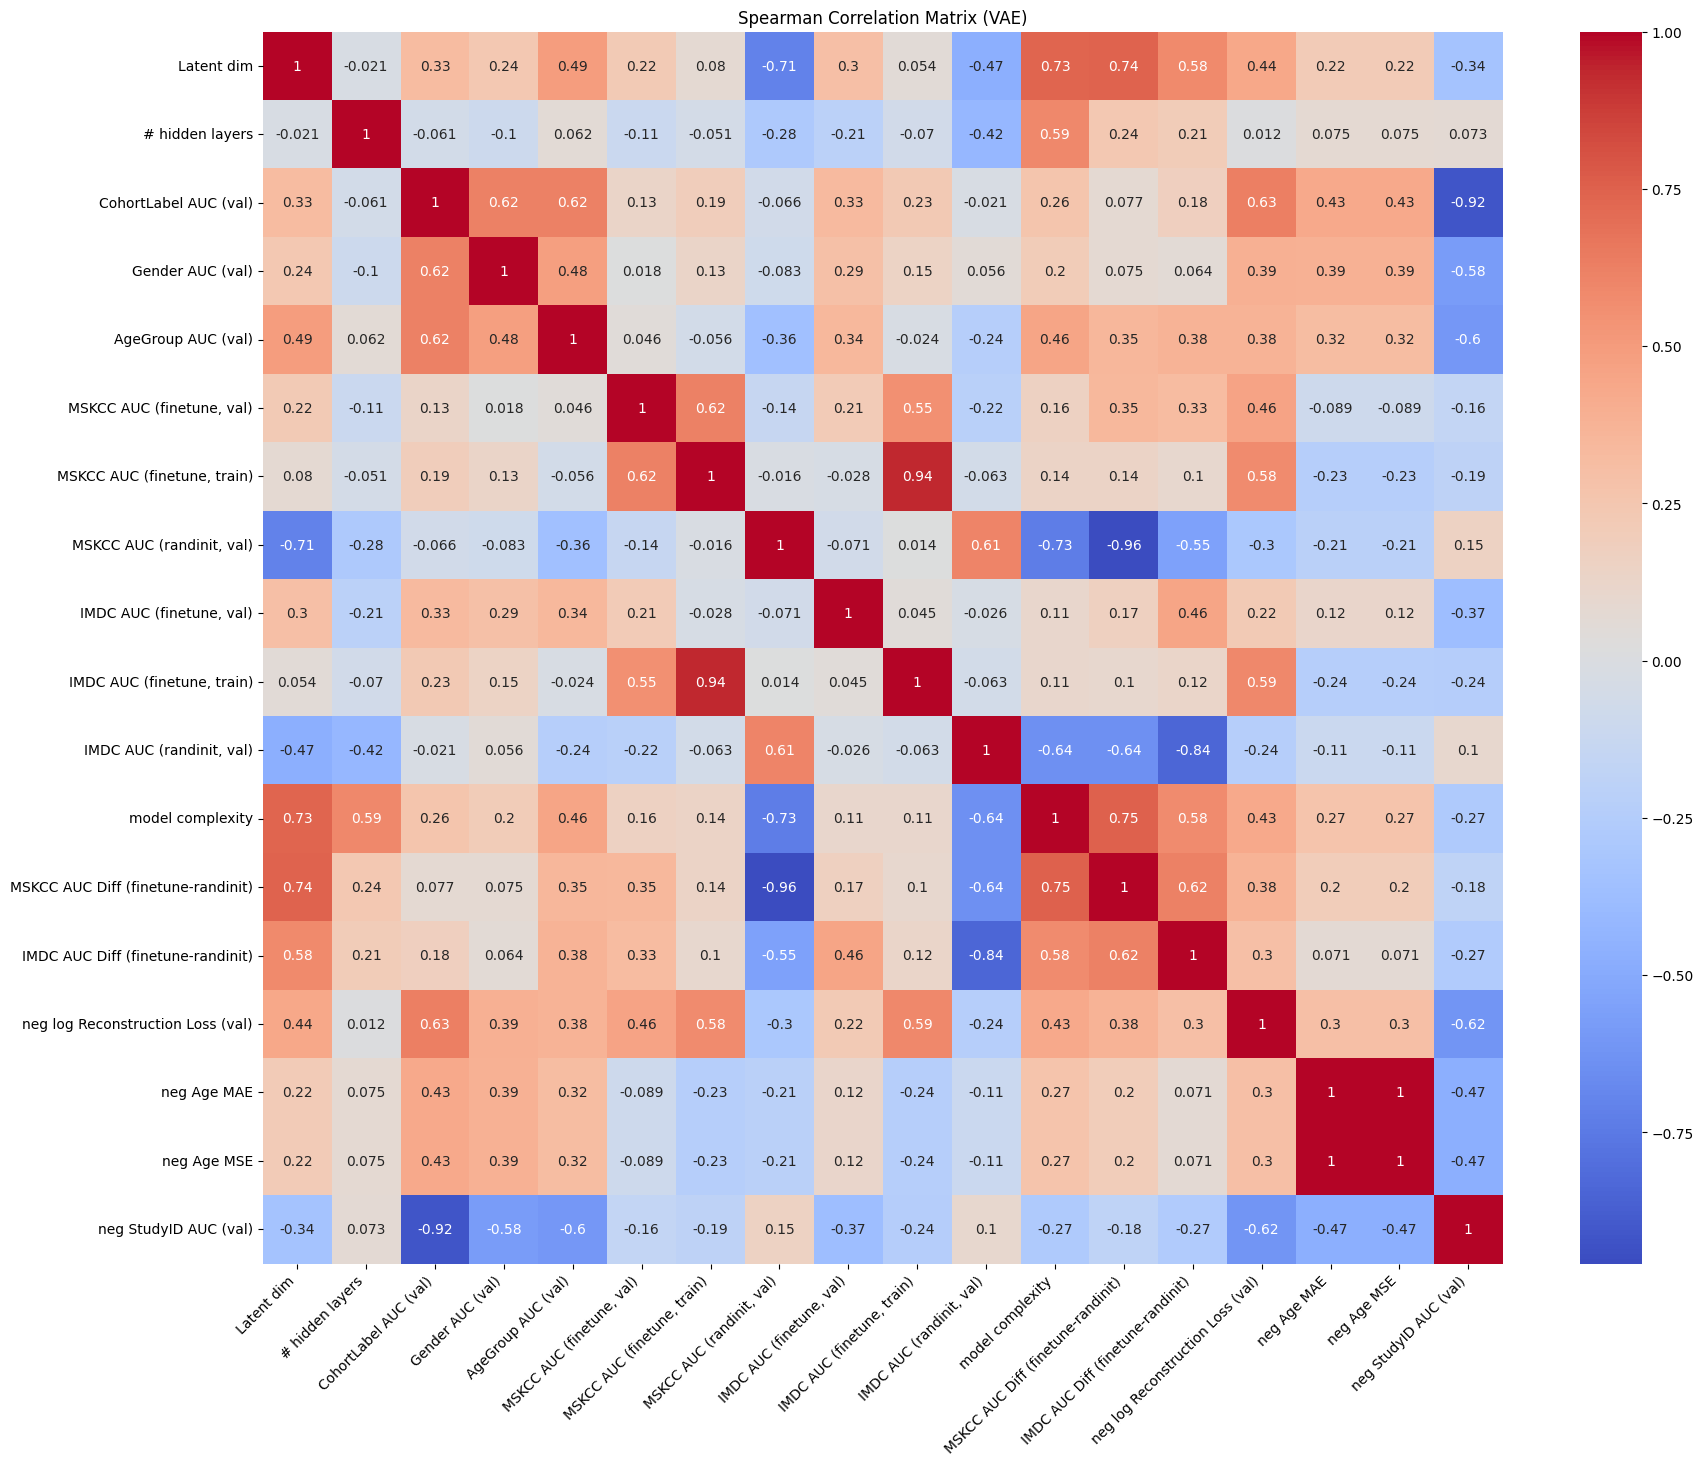

In [38]:
# Compute the correlation matrix

corr_matrix = vae_model_clean.corr(method='spearman')

# Plot the correlation matrix
# make the plot bigger
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix (VAE)')

# rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.savefig('/Users/jonaheaton/Desktop/vae_correlation_matrix.png')

<Figure size 2600x2400 with 0 Axes>

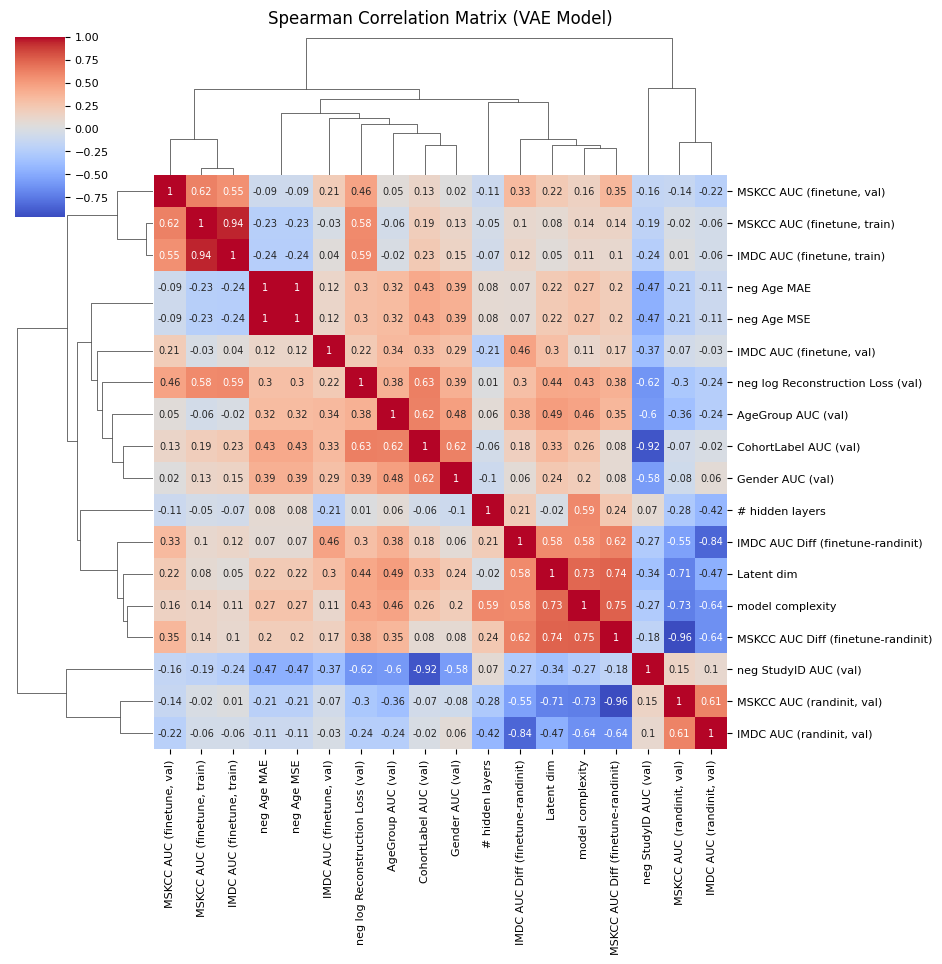

In [39]:
# sns.set_context('notebook')
nonan_corr_matrix = corr_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all')
nonan_corr_matrix = nonan_corr_matrix.dropna(axis=0).dropna(axis=1).round(2)

plt.figure(figsize=(26, 24))
cax = sns.clustermap(nonan_corr_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 7})
plt.xticks(rotation=45, ha='right')

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# Set axis label size
cax.ax_heatmap.tick_params(axis='both', which='both', labelsize=8)

# add a title to the clustergird
cax.ax_col_dendrogram.set_title('Spearman Correlation Matrix (VAE Model)')

plt.savefig('/Users/jonaheaton/Desktop/vae_clustered_correlation_matrix.png')